In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def is_numeric(s):
    if pd.isna(s):
        return False
    try:
        float(s)
        return True
    except:
        return False

def PS1_Q1(df):
    int_columns = [
    'PERMNO',
    'SHRCD',
    'EXCHCD',
    'RET',
    'DLRET',
    'PRC',
    'SHROUT'
    ]
    df[int_columns] = df[int_columns].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    df['date'] = pd.to_datetime(df['date'])
    df['RET_FULL'] = (1 + df['RET'].fillna(0)) * (1 + df['DLRET'].fillna(0)) - 1
    df['MC'] = df['PRC'].abs() * df['SHROUT']
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df = df[df['SHRCD'].isin([10, 11])]
    df = df[df['EXCHCD'].isin([1, 2, 3])]
    df = df.sort_values(['PERMNO', 'date'])
    df['Lag_MC'] = df.groupby('PERMNO')['MC'].shift(1)
    grouped = df.dropna(subset=['Lag_MC', 'RET_FULL']).copy()
    stock_mv = grouped.groupby(['Year', 'Month'])['Lag_MC'].sum()
    ewret = grouped.groupby(['Year', 'Month'])['RET_FULL'].mean()
    vwret = grouped.groupby(['Year', 'Month'], group_keys=False).apply(
        lambda x: (x['Lag_MC'] * x['RET_FULL']).sum() / x['Lag_MC'].sum(),
        include_groups=False
    )
    result_ = pd.DataFrame({
        'Stock lag MV': stock_mv,
        'Stock Ew Ret': ewret,
        'Stock Vw Ret': vwret
    }).reset_index()

    result = result_.copy()
    result['Date'] = pd.to_datetime(result['Year'].astype(str) + '-' + result['Month'].astype(str) + '-01')

    plt.style.use('dark_background')

    plt.figure(figsize=(15, 6))
    plt.plot(result['Date'], result['Stock Vw Ret'], color='#39FF14', linewidth=2)
    plt.title('Value-Weighted Return Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Return', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot(result['Date'], result['Stock Ew Ret'], color='#FF073A', linewidth=2)
    plt.title('Equal-Weighted Return Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Return', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    return result_

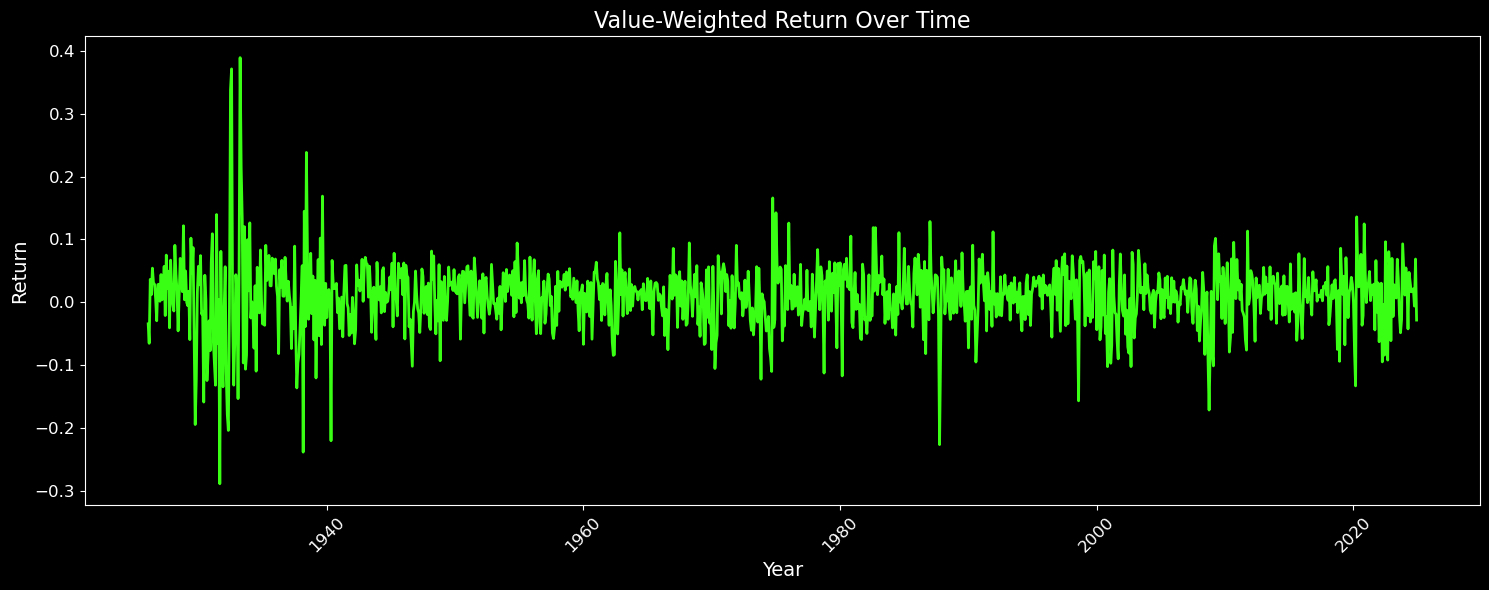

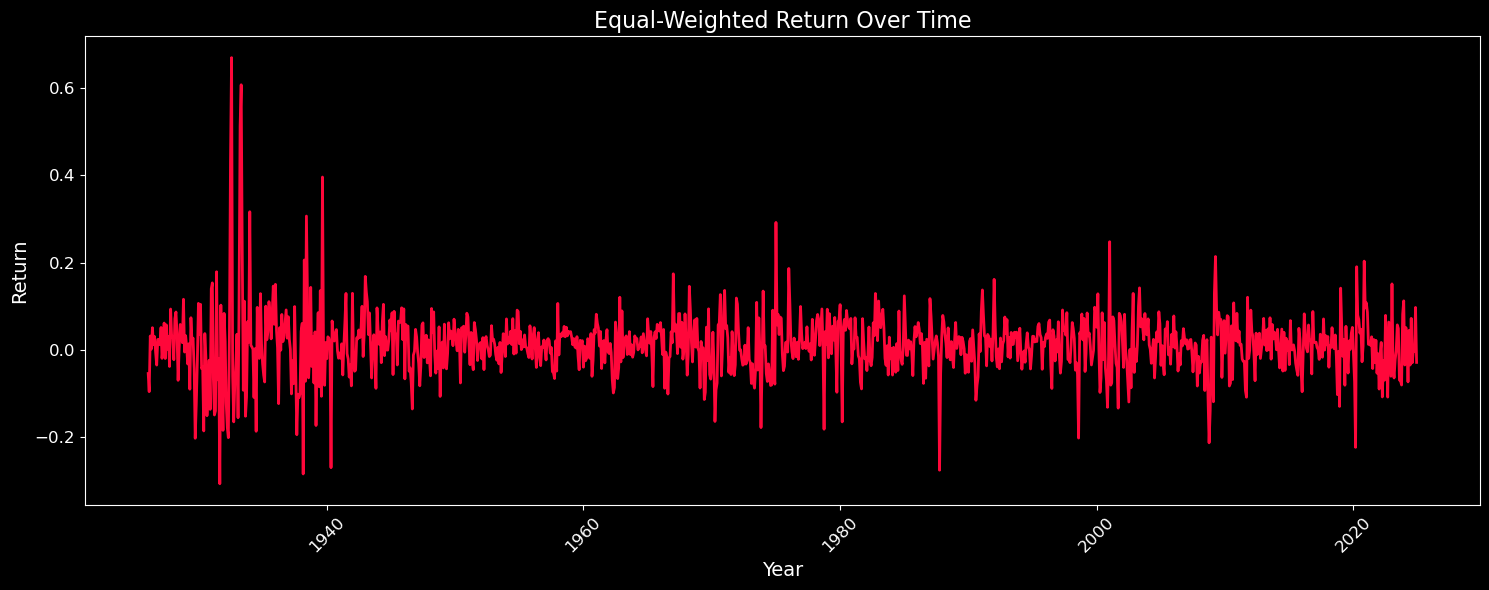

In [8]:
file = 'WRDS_monthly_PS1.csv'
df = pd.read_csv(file)
result = PS1_Q1(df)

In [3]:
fama_file = 'F-F_Research_Data_Factors.CSV'
ff = pd.read_csv(fama_file)
ff['Date'] = ff['Date'].astype(str)
ff['Year'] = ff['Date'].str[:4].astype(int)
ff['Month'] = ff['Date'].str[4:].astype(int)
ff['Mkt-RF'] = ff['Mkt-RF'] / 100
ff['RF'] = ff['RF'] / 100

In [4]:
from scipy.stats import skew, kurtosis

def PS1_Q2(Monthly_CRSP_Stocks, FF_mkt):
    merged = pd.merge(Monthly_CRSP_Stocks, FF_mkt, on=['Year', 'Month'])
    merged['CRSP_Excess'] = merged['Stock Vw Ret'] - merged['RF']
    crsp = merged['CRSP_Excess']
    ff = merged['Mkt-RF']

    def get_metrics(r):
        ann_mean = np.mean(r) * 12
        ann_std = np.std(r, ddof=1) * np.sqrt(12)
        sharpe = ann_mean / ann_std
        skewness = skew(r, nan_policy='omit')
        excess_kurt = kurtosis(r, fisher=True, nan_policy='omit')
        return [ann_mean, ann_std, sharpe, skewness, excess_kurt]

    crsp_stats = get_metrics(crsp)
    ff_stats = get_metrics(ff)

    result = pd.DataFrame({
        'CRSP_Market_Excess': crsp_stats,
        'FF_Market_Excess': ff_stats
    }, index=[
        'Annualized Mean',
        'Annualized Std Dev',
        'Annualized Sharpe Ratio',
        'Skewness',
        'Excess Kurtosis'
    ])

    return result


In [5]:
Q2_result =  PS1_Q2(result[5:], ff)
Q2_result.head()

,CRSP_Market_Excess,FF_Market_Excess
Annualized Mean,0.082574,0.082375
Annualized Std Dev,0.184137,0.184542
Annualized Sharpe Ratio,0.448436,0.446374
Skewness,0.160887,0.153427
Excess Kurtosis,7.382452,7.405690


In [6]:
def PS1_Q3(Monthly_CRSP_Stocks, FF_mkt):
    merged = pd.merge(Monthly_CRSP_Stocks, FF_mkt, on=['Year', 'Month'])
    merged['CRSP_Excess'] = merged['Stock Vw Ret'] - merged['RF']
    merged = merged[(merged['Year'] > 1926) | ((merged['Year'] == 1926) & (merged['Month'] >= 7))]
    corr = np.corrcoef(merged['CRSP_Excess'], merged['Mkt-RF'])[0, 1]
    max_diff = np.max(np.abs(merged['CRSP_Excess'] - merged['Mkt-RF']))
    return [round(corr, 8), max_diff]

In [7]:
Q3_result =  PS1_Q3(result[5:], ff)
print(Q3_result)

[0.99999244, 0.0030579450769784855]


In [9]:
result.to_csv("PS1_Q1.csv")